### Notebook to Research diabetes onset 


#### Matched Controls Diabetes Onset Curve Construction Details

   1. <div style="background:Aliceblue"> <strong>Get all the canary patients who have their CC_DIABETES flag equals 0
    on their registration date.</strong>
   </div>
   
       - Pick a matching algorithm
       
   2. <div style="background:Aliceblue"><strong> Create the macthed population</strong> </div>
   
       - For each canary patient let their registration month be $i$
       - Find N(for example 50)  control patients to match this canary patient from the pmpm 
       patients on month i who have CC_DIABETES = 0 on month i. For example a matching specification could require the N patients should have the same age 
       and then be the nearest neighbors according to other features(log costs, cc codes etc).
       - Set the index date for these pmpm controls patients to be month $i$.
       - This forms a matched set of roughly 50 times the number of canary patients and each control has an index date.
   
   3. <div style="background:Aliceblue"><strong> Compute Onset of Diabetes for month $i$<strong></div> 
   
       - Get all the matched controls with index date prior to month $i$.
       - For Month i we define the total number of Diabetes Onsets(DO) as the number of subjects from <strong> 2 </strong> that had
        the flag $CC_{DIABETES} = 1$ at Month $(i)$ and $CC_{DIABETES} = 0$ at Month $(i-1)$ (Note these patients must be in pmpm on both months).
       - S is the total number of matched controls included in the pmpm both in month $i$ and month $i-1$
       - For Month i we define the diabetes onset rate(DOR) as: $DOR =  1000DO/S$

    <div style="background:Lightskyblue"> <strong>Suggestion:</strong> Remove from  $S$ the subjects that  have the flag $CC_{DIABETES} = 1$ at month $i-1$
    </div>

   

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython


In [2]:
%reload_ext Cython

In [3]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [4]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load Pmpm, Canary data

In [5]:
%%time
canary_p = '../../../temp/ref_ccm.p'
pmpm_p = '../../../temp/pmpm_ccm.p'
preg_p = '../../../data/pregnancies'

preg = pq.read_table(preg_p).to_pandas()
canary = pd.read_pickle(canary_p)
pmpm = pd.read_pickle(pmpm_p)

#drop pmpm duplicates
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)
canary.drop_duplicates(subset = ['PERS_ID'], inplace = True)

CPU times: user 15.3 s, sys: 17.5 s, total: 32.7 s
Wall time: 56.6 s


pmpm.MEDICAID_LOB.unique()

### Include Line of Bussiness Feature 1 Not medicaid 0 medicaid

medicaid_mask = pmpm.MEDICAID_LOB.str.contains(r'.*Medicaid-.*')
pmpm['LOB'] = 1
pmpm.loc[medicaid_mask, 'LOB'] = 0

In [6]:
preg = preg.rename(mapper = {'person_id':'PERS_ID'}, axis = 1)
preg = pd.melt(preg, id_vars = ['PERS_ID'], value_vars=['stay_start_date', 'stay_end_date'], value_name='MYR')
preg.MYR = preg.MYR.apply(lambda x: x.year*100+x.month)
preg.drop(labels = 'variable', axis = 1, inplace = True)
preg['PREGNANCY'] = 1

In [7]:
%%time
pmpm = pmpm.merge(preg, how = 'left', on = ['PERS_ID', 'MYR'])
pmpm.PREGNANCY = pmpm.PREGNANCY.fillna(value = 0)
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)

CPU times: user 35.5 s, sys: 19.5 s, total: 54.9 s
Wall time: 54.9 s


In [8]:
from utils import ip_er2

In [9]:
%%time
pmpm = pmpm.sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
pmpm['IP_BIN'] = ((pmpm.ALLOW_IP>0) & (pmpm.PREGNANCY == 0)).astype(int)
pmpm['ER_BIN'] = ((pmpm.ALLOW_ER>0) & (pmpm.PREGNANCY == 0)).astype(int)
pmpm['ACUTE'] =  ((pmpm.IP_BIN>0) | (pmpm.ER_BIN > 0 )).astype(int)

CPU times: user 42.1 s, sys: 6.67 s, total: 48.8 s
Wall time: 48.8 s


In [10]:
%%time
pmpm[['IP_C', 'ER_C', 'ACUTE_C']] = pmpm.groupby('PERS_ID', sort = False)[['IP_BIN', 'ER_BIN', 'ACUTE']].cumsum().reset_index(drop = True)
pmpm[['IP_BIN6', 'ER_BIN6', 'ACUTE6']] = pmpm.groupby('PERS_ID', sort = False)[['IP_C', 'ER_C', 'ACUTE_C']].diff(6).fillna(pmpm[['IP_C', 'ER_C','ACUTE_C']]).reset_index(drop = True)
pmpm[['IP_BIN2', 'ER_BIN2','ACUTE2']] = pmpm.groupby('PERS_ID', sort = False)[['IP_C', 'ER_C','ACUTE_C']].diff(2).fillna(pmpm[['IP_C', 'ER_C','ACUTE_C']]).reset_index(drop = True)

CPU times: user 7min 39s, sys: 24.1 s, total: 8min 3s
Wall time: 7min 55s


#undersample
test = test.sample(random_state = 0, frac = 0.01).reset_index(drop = True)
test = test.sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

%%time

test[['IP_C', 'ER_C']] = test.groupby('PERS_ID', sort = False)[['IP_BIN', 'ER_BIN']].cumsum().reset_index(drop = True)
test[['IP_BIN2', 'ER_BIN2']] = test.groupby('PERS_ID', sort = False)[['IP_C', 'ER_C']].diff(6).fillna(test[['IP_C', 'ER_C']]).reset_index(drop = True)

In [11]:
pmpm.head()

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  2561295  201510        F               38        190       0.0       0.0        0             0                  0       0          0                    0             0          0              0          0           0       0                 0            0                  0                  0                     0        0                   0              0                        0                  0            0                0          0                      0            0                0            0                  0                 0               0                     0                       0                     0                       0                           0               0               0                 0                0                  0                0               0             0            0               0             0         0               0            0                   0                      0                      0           0                0   
1  2561295  201511        F               38          3       0.0       0.0        0             0                  0       0          0                    0             0          0              0          0           0       0                 0            0                  0                  0                     0        0                   0              0                        0                  0            0                0          0                      0            0                0            0                  0                 0               0                     0                       0                     0                       0                           0               0               0                 0                0                  0                0               0             0            0               0             0         0               0            0                   0                      0                      0           0                0   
2  2561295  201512        F               38          0       0.0       0.0        0             0                  0       0          0                    0             0          0              0          0           0       0                 0            0                  0                  0                     0        0                   0              0                        0                  0            0                0          0                      0            0                0            0                  0                 0               0                     0                       0                     0                       0                           0               0               0                 0                0                  0                0               0             0            0               0             0         0               0            0                   0                      0                      0           0                0   

### Process Canary data 
1. Drop register dates beyond pmpm max date
2. Transform register date to MYR
3. Keep only ids and MYR

### Get Controls and Treated
> ***a)Controls are all the patients that did not enrolled in canary program at any point  
b)Treated are the patients that enrolled at some point in the Canary Plan***

In [12]:
%%time
canary2 = process_canary(canary, pmpm.MYR.max())
treated, controls = get_tc(pmpm.copy(), canary2)

CPU times: user 28.5 s, sys: 9.99 s, total: 38.4 s
Wall time: 38.4 s


In [13]:
canary.principal_reason.value_counts().head(5)

Other: please specify                                             10181
Behavioral Health Other (Specify under Additional Information)     8440
Coordination of Care                                               5296
High Risk Pregnancy                                                4139
Diabetes                                                           2950
Name: principal_reason, dtype: int64

In [14]:
%time
#reduce pmpm dimension and treated dimension
ids = list(pd.DataFrame(controls.PERS_ID.unique()).sample(frac = 0.8)[0])
controls = controls[controls.PERS_ID.isin(ids)].reset_index(drop = True)

#ids2 = list(pd.DataFrame(treated.PERS_ID.unique()).sample(frac = 0.005)[0])
#treated = treated[treated.PERS_ID.isin(ids2)].reset_index(drop = True)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


### filter by principal reason

In [15]:
ids2 = canary[canary.principal_reason == "Diabetes"].PERS_ID.unique()
treated = treated[treated.PERS_ID.isin(ids2)].reset_index(drop = True)

In [16]:
controls.PERS_ID.unique().shape, treated.PERS_ID.unique().shape

Keep Canary Patients from their date of registration and onwards who did not have **CC_DIABETES** flag on, on their date of registration.

In [17]:
%%time
treated2 = in_canary(treated.copy(), canary2)
#treated2 = filter_first_month_diabetes(treated2.copy())
treated2.drop(columns = ['IN_CANARY'], inplace = True)

CPU times: user 15 s, sys: 184 ms, total: 15.1 s
Wall time: 15.1 s


In [18]:
treated2.PERS_ID.unique().shape

In [19]:
#cols = list(col for col in treated2.columns if col not in ['PERS_ID', 'MYR'])
#columns_to_match = cols
columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'IP_BIN2', 'ER_BIN2', 'ACUTE', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6']

In [20]:
%%time
"""
columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
hier_cols = ['IP_BIN2', 'ER_BIN2']
hier_range = [2,2]
nnr_func_args = {'match_on':columns_to_match, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5, 'onset' : ""}
matched0, matched_data0 = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

"""
#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
propensity_func_args = {'match_on':columns_to_match, 'neighbors_per_treated': 1, 'onset': "CC_DIABETES", "onset_val" : 1}
matched0, matched_data0 = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           propensity_func, 
                                           propensity_func_args)


Mathcing Function: propensity_func
Propensity Score Matching...fitting model
Fitted: GradientBoostingClassifier
Creating Matched Set...


0it [00:00, ?it/s]

iter: 0


200it [22:24,  6.26s/it]

iter: 200


400it [44:19,  6.62s/it]

iter: 400


600it [1:05:55,  6.24s/it]

iter: 600


800it [1:27:16,  6.57s/it]

iter: 800


1000it [1:48:58,  6.68s/it]

iter: 1000


1200it [2:11:12,  6.78s/it]

iter: 1200


1400it [2:32:41,  6.51s/it]

iter: 1400


1600it [2:54:01,  6.31s/it]

iter: 1600


1607it [2:54:45,  6.52s/it]


CPU times: user 2h 8s, sys: 56min 57s, total: 2h 57min 5s
Wall time: 2h 55min 26s


####  In addition to the previously created matched groups create a random group

In [21]:
Path('./tempPropSelection').mkdir(exist_ok = True)
p = './tempPropSelection/'
matched_data0.to_pickle(p+'match0.p')
treated2.to_pickle(p+'treated0.p')

In [22]:
random_matching_func_args = {'neighbors_per_treated': 5}
random_controls = matched_population(treated2.copy(), 
                                       controls.copy(),
                                       random_matching_func, 
                                       random_matching_func_args)

Mathcing Function: random_matching_func


In [23]:
random_controls.to_pickle(p+'random.p')

#### Calculate the Diabetes onset for each of the created groups
1. Group 0: Group of treated patients cluster 0
2. Group 1: Group of treated patients Cluster 1
3. Group 2: Group of matched control patients to Group 0
4. Group 3: Group of matched control patients to Group 1
5. Group 4: Random Group

In [24]:
from utils import statistics_first_month

In [25]:
pmpm2 = pmpm
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [26]:
%%time
tr_desc0, Ntr, treated_first_month = statistics_first_month(treated2, columns_to_match, return_array = True)
tr_desc0 = tr_desc0.T



con_desc0, Ncon, controls_first_month = statistics_first_month(matched_data0, columns_to_match, return_array = True)
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0 = con_desc0.T

pmpm_desc, Npmpm = statistics_first_month(pmpm2, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_desc = pmpm_desc.T

random_desc, Nra = statistics_first_month(random_controls, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_desc = random_desc.T

CPU times: user 5min 3s, sys: 11.3 s, total: 5min 14s
Wall time: 5min 14s


In [27]:
import scipy.stats as sts

In [28]:
args = {'mean1':tr_desc0['mean'], 'std1':tr_desc0['std'], 'mean2':con_desc0['mean'], 'std2':con_desc0['std'], 'nobs1': np.full(len(tr_desc0), Ntr) , 'nobs2': np.full(len(tr_desc0), Ncon)}
stats, pval = sts.ttest_ind_from_stats(**args)
stats = pd.DataFrame(stats, columns = ['t-stat'])
stats['pval'] = pval

In [29]:
alli = pd.concat((tr_desc0['mean'], con_desc0['mean'], stats, pmpm_desc['mean'], random_desc['mean']), axis = 1, keys = ['Treated', 'Matched Controls', 'T-Test', 'Genaral Population', 'Random'] )

## Statistics on matching date

In [30]:
alli

Treated Matched Controls    T-Test               Genaral Population      Random
                        mean             mean    t-stat          pval               mean        mean
AGE_AT_MIDMONTH    53.835280        54.144625 -0.601373  5.476346e-01          35.256735   35.576804
ALLOW_AMT        1545.461586      1498.120521  0.234706  8.144525e-01         501.015156  369.753011
MBR_GNDR            0.493546         0.529642 -2.030017  4.243845e-02           0.481626    0.470508
CC_TOBACCO          0.177013         0.138111  2.999809  2.722574e-03           0.041088    0.042717
CC_PRESSURE         0.044253         0.029967  2.119049  3.416409e-02           0.004090    0.003104
CC_OBESITY          0.390904         0.371336  1.132056  2.576968e-01           0.050181    0.065814
CC_HYPERTENSION     0.604794         0.592834  0.685667  4.929732e-01           0.102356    0.105178
CC_HYPOTHYROID      0.104487         0.119870 -1.371069  1.704508e-01           0.025070    0.032907
CC_DX_CNT           4.954518         5.089902 -1.265387  2.058258e-01           0.920962    1.010058
IP_BIN2             0.108789         0.039739  6.867470  7.836223e-12           0.017570    0.006581
ER_BIN2             0.103872         0.050163  5.177507  2.389417e-07           0.021684    0.029057
ACUTE               0.061463         0.042345  2.417349  1.569029e-02           0.037708    0.017757
ACUTE2              0.189305         0.081433  7.941426  2.753417e-15           0.037708    0.034645
ACUTE6              0.391518         0.222150  7.044207  2.279314e-12           0.037708    0.099342
IP_BIN6             0.172711         0.096417  5.214914  1.957442e-07           0.017570    0.018875
ER_BIN6             0.255071         0.142020  5.734006  1.073280e-08           0.021684    0.082950

In [31]:
tr_desc0A = treated2[columns_to_match].describe().loc[['mean', 'std']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc0A = tr_desc0A.T


con_desc0A = matched_data0[columns_to_match].describe().loc[['mean', 'std']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0A = con_desc0A.T


pmpm_descA = pmpm2[columns_to_match].describe().loc[['mean','std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_descA = pmpm_descA.T

random_descA = random_controls[columns_to_match].describe().loc[['mean','std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_descA = random_descA.T



#### Univariate Means of the Groups under Study of interesting features (Statistics for whole populations)
>The "Sick groups" have:  
a) Older age  
b) More Expenditures  
c) Smoke More  
d) Have More People with Hypertension


In [32]:
args = {'mean1':tr_desc0A['mean'], 'std1':tr_desc0A['std'],
        'mean2':con_desc0A['mean'], 'std2':con_desc0A['std'],
        'nobs1': np.full(len(tr_desc0), len(treated2)) , 'nobs2': np.full(len(tr_desc0), len(matched_data0))}
stats, pval = sts.ttest_ind_from_stats(**args)
stats = pd.DataFrame(stats, columns = ['t-stat'])
stats['pval'] = pval

In [33]:
alli2 = pd.concat((tr_desc0A, con_desc0A, stats['pval'], pmpm_descA['mean'], random_descA['mean']), axis = 1, keys = ['Treated',
                                                                                 'Matched Controls','T-Test',
                                                                                'Genaral Population', 
                                                                                 'Random'] )
alli2

Treated              Matched Controls                      T-Test Genaral Population      Random
                        mean          std             mean          std           pval               mean        mean
AGE_AT_MIDMONTH    56.525111    13.260262        56.702065    14.161236   4.401037e-02          38.128488   37.516761
ALLOW_AMT        1519.160424  7702.808206      1301.681549  4179.475708   6.868813e-08         486.846157  371.063102
MBR_GNDR            0.479710     0.499593         0.522247     0.499510   3.632152e-40           0.471587    0.471910
CC_TOBACCO          0.179591     0.383850         0.126558     0.332481  4.124801e-116           0.060322    0.049061
CC_PRESSURE         0.048680     0.215199         0.031899     0.175734   5.202210e-40           0.006250    0.002827
CC_OBESITY          0.453263     0.497816         0.423866     0.494175   2.601792e-20           0.107772    0.098955
CC_HYPERTENSION     0.617278     0.486056         0.595784     0.490745   6.869722e-12           0.155155    0.128830
CC_HYPOTHYROID      0.124666     0.330343         0.130735     0.337114   4.569244e-03           0.040193    0.039645
CC_DX_CNT           5.566861     3.312435         5.192867     3.120325   5.185881e-73           1.518776    1.257546
IP_BIN2             0.038666     0.207055         0.020992     0.148694   7.537940e-52           0.011970    0.006339
ER_BIN2             0.072844     0.287958         0.040902     0.208395   8.364907e-86           0.036681    0.027245
ACUTE               0.050592     0.219166         0.029367     0.168835   2.921110e-63           0.023586    0.016207
ACUTE2              0.103508     0.342223         0.058951     0.250669  1.683491e-116           0.046542    0.032480
ACUTE6              0.314485     0.739002         0.176658     0.492920  5.680486e-250           0.131563    0.098012
IP_BIN6             0.117034     0.412188         0.062413     0.275770  2.354740e-127           0.033013    0.018571
ER_BIN6             0.222161     0.626760         0.122836     0.404510  1.124437e-184           0.104381    0.082617

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Matrices and Figures for the paper

In [34]:
#mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco use', 'Pressure', 'Obesity', 
                                     #'Hypertension', 'Hypothyroid', 'Disease Count', 'Inpatient Visits', 'Emergency Vistits', 'Line of Bussiness']))
mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [35]:
p = Path('./res/figs')
p.mkdir(parents = True, exist_ok = True)

In [36]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

1. treated_first_month
2. controls_first_month

In [37]:
from diabetes_onset_plotter import plot_hist


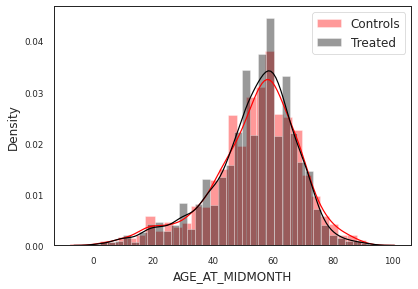

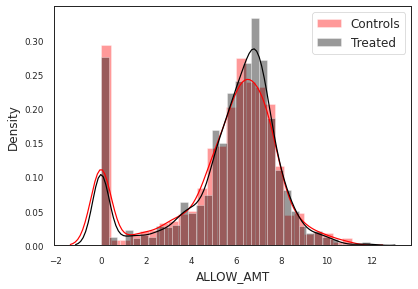

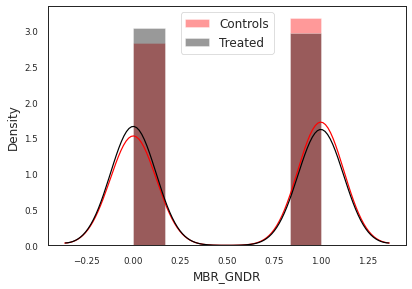

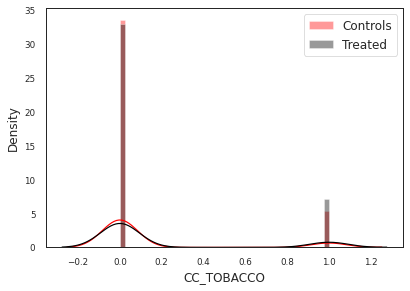

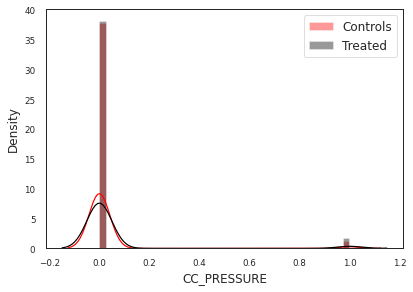

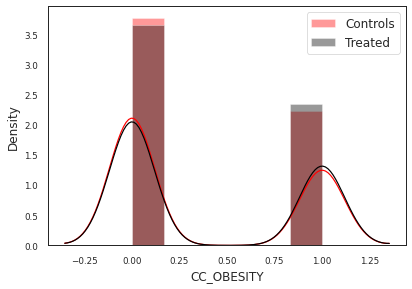

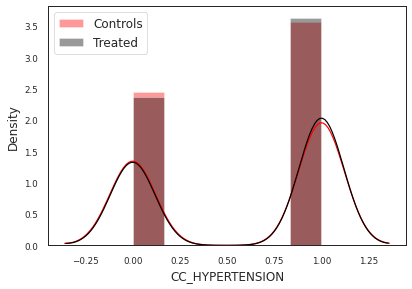

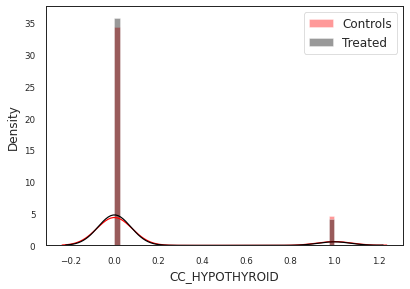

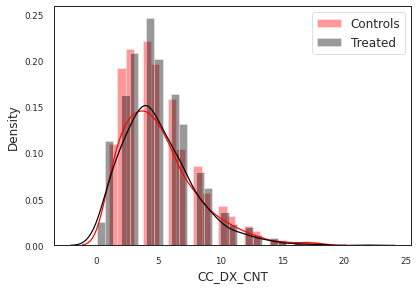

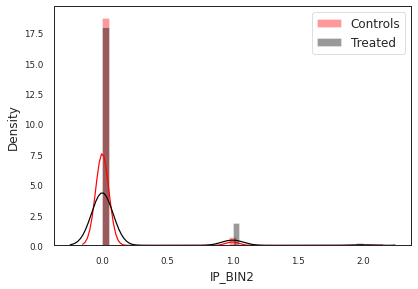

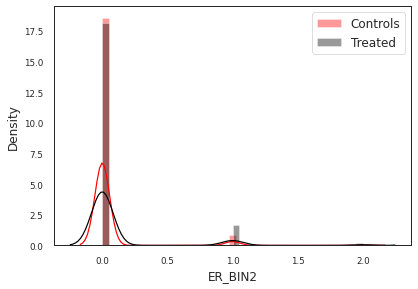

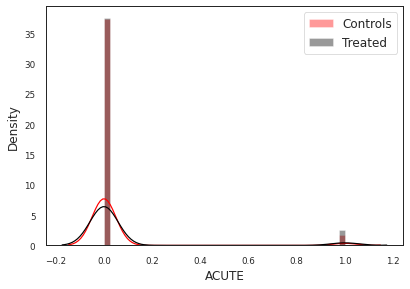

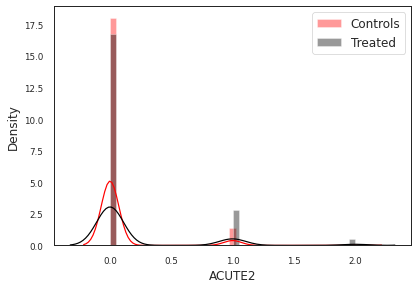

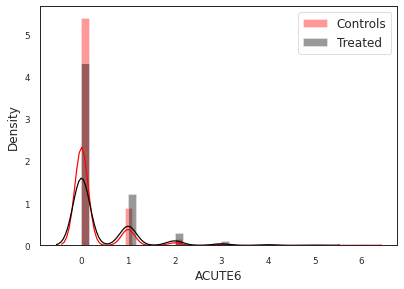

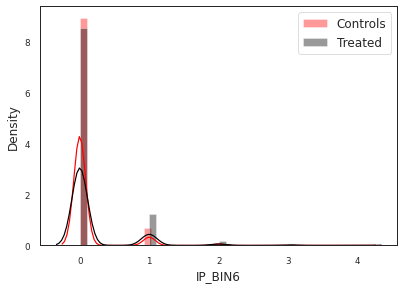

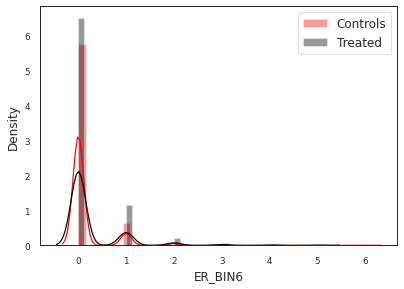

In [38]:
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = 'res/figs/',
                dist_plot_args = dist_plot_args)

Save Three arrays
1. All Statistics
2. Only Means
3. Difference T-Statistic Pvalues

In [39]:
from diabetes_onset_plotter import save_arrays
p2 = Path('./res/tabs')
p2.mkdir(parents = True, exist_ok = True)
paths = ['./res/tabs/all_stats.csv', './res/tabs/only_means.csv', './res/tabs/only_stats.csv']
(all_paper, only_means, only_stats) = save_arrays(alli, paths, mapping)

In [40]:
all_paper


Treated  Matched Controls  T-Statistic  p-value  General Population  Random Match  Difference
AGE_AT_MIDMONTH    53.835            54.145       -0.601    0.548              35.257        35.577      -0.310
ALLOW_AMT        1545.462          1498.121        0.235    0.814             501.015       369.753      47.341
MBR_GNDR            0.494             0.530       -2.030    0.042               0.482         0.471      -0.036
CC_TOBACCO          0.177             0.138        3.000    0.003               0.041         0.043       0.039
CC_PRESSURE         0.044             0.030        2.119    0.034               0.004         0.003       0.014
CC_OBESITY          0.391             0.371        1.132    0.258               0.050         0.066       0.020
CC_HYPERTENSION     0.605             0.593        0.686    0.493               0.102         0.105       0.012
CC_HYPOTHYROID      0.104             0.120       -1.371    0.170               0.025         0.033      -0.016
CC_DX_CNT           4.955             5.090       -1.265    0.206               0.921         1.010      -0.135
IP_BIN2             0.109             0.040        6.867    0.000               0.018         0.007       0.069
ER_BIN2             0.104             0.050        5.178    0.000               0.022         0.029       0.054
ACUTE               0.061             0.042        2.417    0.016               0.038         0.018       0.019
ACUTE2              0.189             0.081        7.941    0.000               0.038         0.035       0.108
ACUTE6              0.392             0.222        7.044    0.000               0.038         0.099       0.170
IP_BIN6             0.173             0.096        5.215    0.000               0.018         0.019       0.077
ER_BIN6             0.255             0.142        5.734    0.000               0.022         0.083       0.113

In [41]:
only_means

Treated  Matched Controls  General Population  Random Match
AGE_AT_MIDMONTH    53.835            54.145              35.257        35.577
ALLOW_AMT        1545.462          1498.121             501.015       369.753
MBR_GNDR            0.494             0.530               0.482         0.471
CC_TOBACCO          0.177             0.138               0.041         0.043
CC_PRESSURE         0.044             0.030               0.004         0.003
CC_OBESITY          0.391             0.371               0.050         0.066
CC_HYPERTENSION     0.605             0.593               0.102         0.105
CC_HYPOTHYROID      0.104             0.120               0.025         0.033
CC_DX_CNT           4.955             5.090               0.921         1.010
IP_BIN2             0.109             0.040               0.018         0.007
ER_BIN2             0.104             0.050               0.022         0.029
ACUTE               0.061             0.042               0.038         0.018
ACUTE2              0.189             0.081               0.038         0.035
ACUTE6              0.392             0.222               0.038         0.099
IP_BIN6             0.173             0.096               0.018         0.019
ER_BIN6             0.255             0.142               0.022         0.083

In [42]:
only_stats

Difference  T-Statistic  p-value
AGE_AT_MIDMONTH      -0.310       -0.601    0.548
ALLOW_AMT            47.341        0.235    0.814
MBR_GNDR             -0.036       -2.030    0.042
CC_TOBACCO            0.039        3.000    0.003
CC_PRESSURE           0.014        2.119    0.034
CC_OBESITY            0.020        1.132    0.258
CC_HYPERTENSION       0.012        0.686    0.493
CC_HYPOTHYROID       -0.016       -1.371    0.170
CC_DX_CNT            -0.135       -1.265    0.206
IP_BIN2               0.069        6.867    0.000
ER_BIN2               0.054        5.178    0.000
ACUTE                 0.019        2.417    0.016
ACUTE2                0.108        7.941    0.000
ACUTE6                0.170        7.044    0.000
IP_BIN6               0.077        5.215    0.000
ER_BIN6               0.113        5.734    0.000